In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.cloud import bigquery
import pandas as pd

# Initialize client
client = bigquery.Client(project="behavior-based-claim")
# Query your table
query = """
SELECT 
  policy_id, subscription_length, customer_age, vehicle_age, model, fuel_type, 
  max_torque, region_code, region_density, segment, claim_status
FROM 
  `behavior-based-claim.InsuranceClaimDataset.insurance_claims`
WHERE
  max_torque IS NOT NULL
"""


In [103]:

# Load to DataFrame
df = client.query(query).to_dataframe()


# Optional: Parse max_torque into numeric features (if not already parsed in SQL)
df[['torque_Nm', 'torque_rpm']] = df['max_torque'].str.extract(r'(\d+)Nm@(\d+)rpm').astype(float)



C:\Users\ssutk2\AppData\Roaming\Python\Python311\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [104]:
df['customer_age']

0        49
1        35
2        51
3        43
4        53
         ..
58587    49
58588    51
58589    42
58590    60
58591    44
Name: customer_age, Length: 58592, dtype: Int64

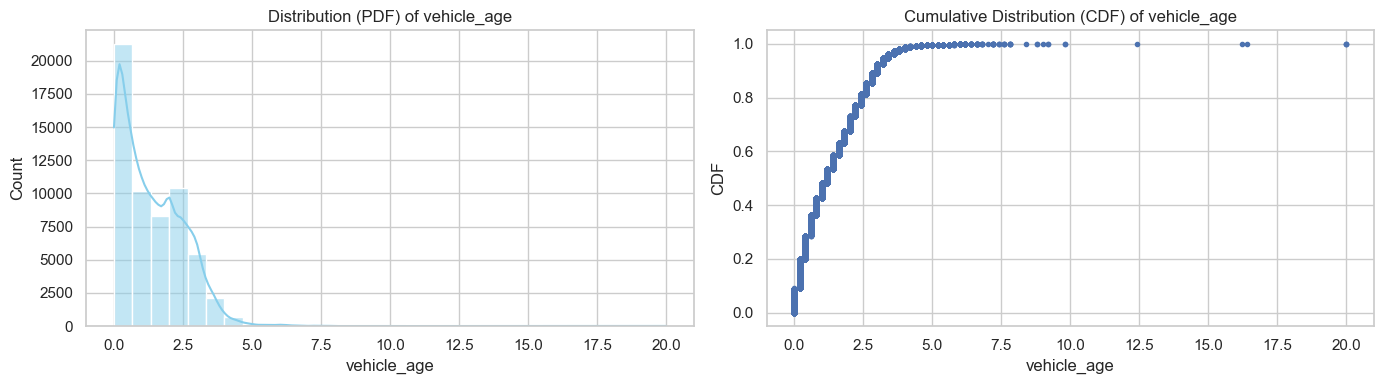

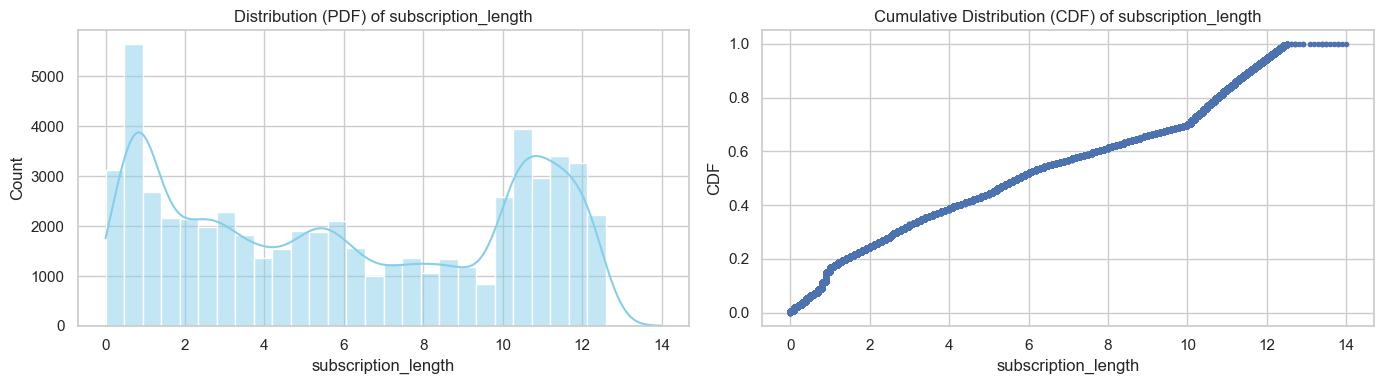

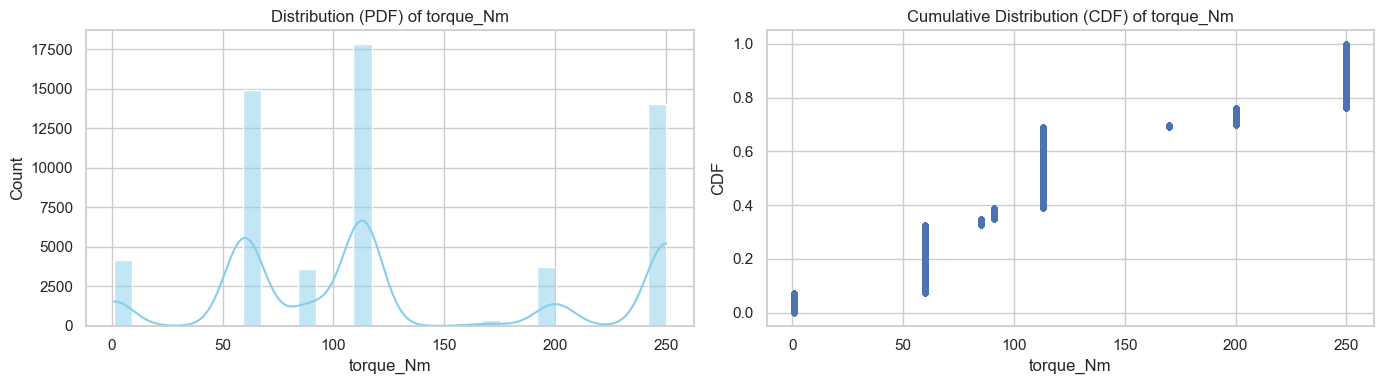

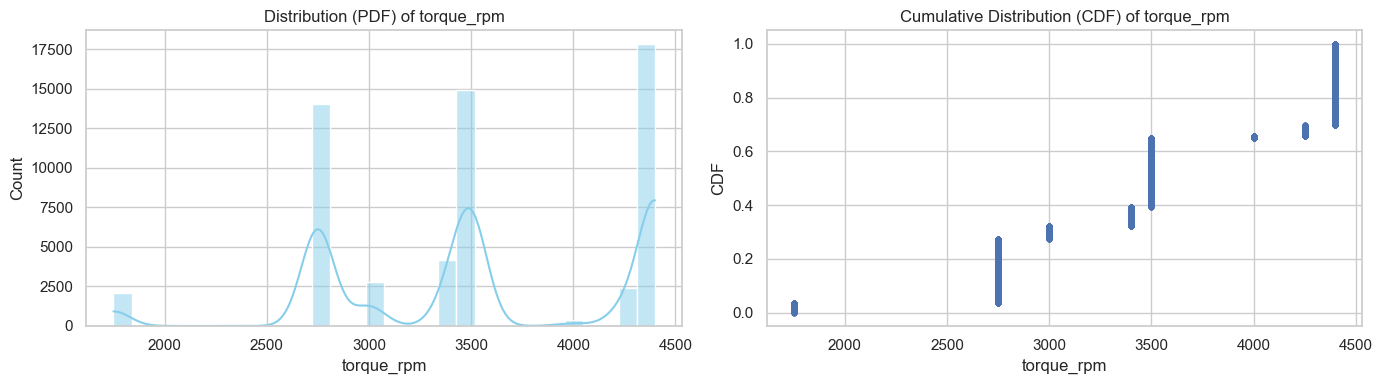

In [105]:
# Set theme
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

# -----------------------------
# ✅ 1. Univariate Distributions
# -----------------------------

univariate_cols = [ 'vehicle_age', 'subscription_length', 'torque_Nm', 'torque_rpm']

# Loop over each column
for col in univariate_cols:
    try:
        # Clean the data
        clean_data = pd.to_numeric(df[col], errors='coerce').dropna()
        
        # Skip if too few points
        if len(clean_data) < 10:
            print(f"Skipping {col} – not enough data after cleaning.")
            continue
        
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))

        # PDF (Histogram with KDE)
        sns.histplot(clean_data, kde=True, ax=ax[0], bins=30, color='skyblue')
        ax[0].set_title(f'Distribution (PDF) of {col}')

        # CDF
        sorted_vals = np.sort(clean_data)
        cdf_vals = np.arange(len(sorted_vals)) / float(len(sorted_vals))
        ax[1].plot(sorted_vals, cdf_vals, marker='.', linestyle='none')
        ax[1].set_title(f'Cumulative Distribution (CDF) of {col}')
        ax[1].set_ylabel('CDF')
        ax[1].set_xlabel(col)

        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"⚠️ Skipping {col} due to error: {e}")


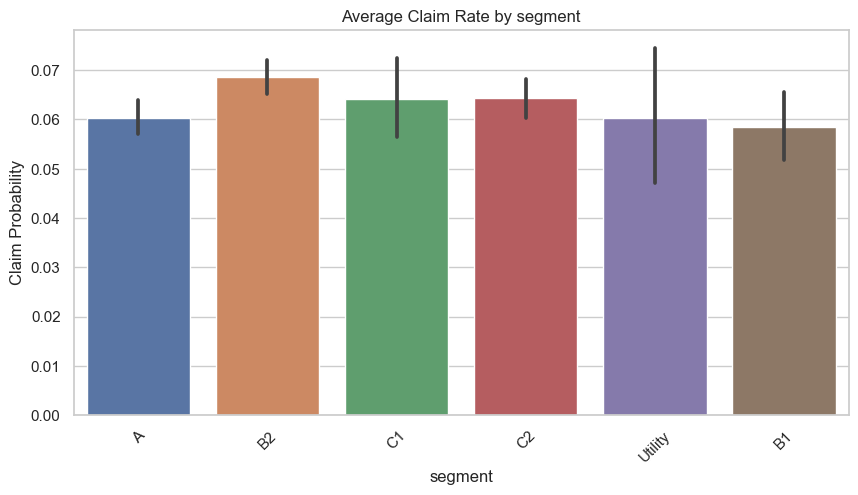

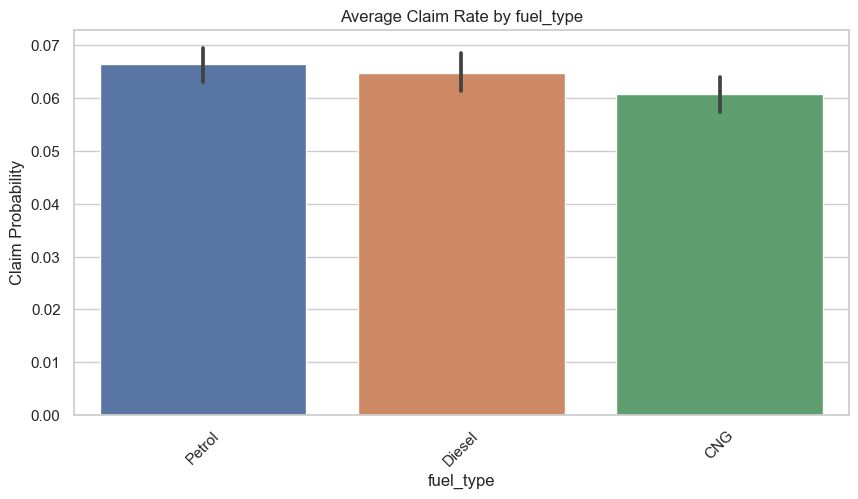

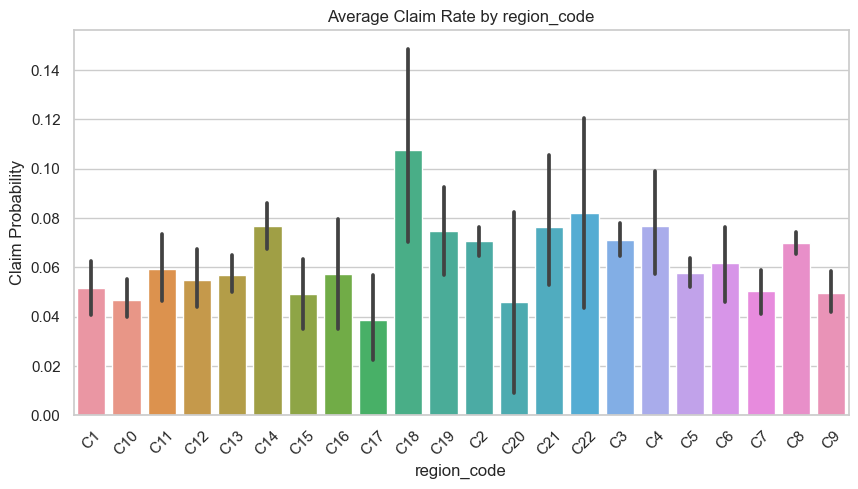

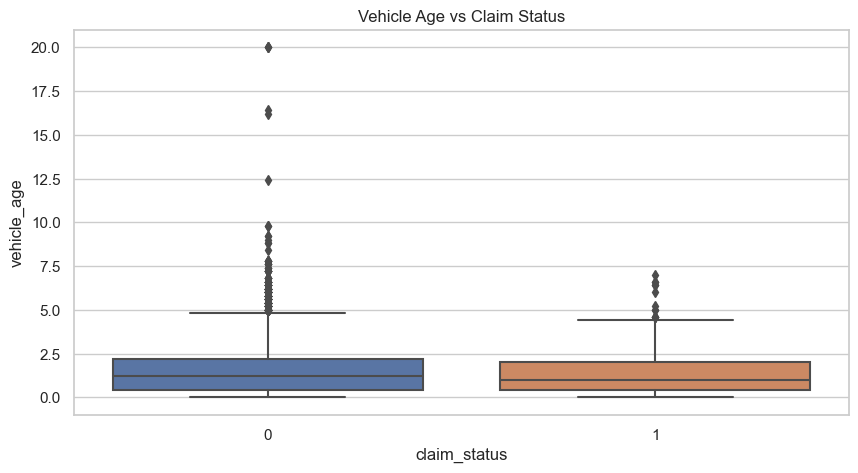

In [106]:

# -------------------------------------------
# ✅ 2. Bivariate Analysis (vs. claim_status)
# -------------------------------------------
categorical_cols = ['segment', 'fuel_type', 'region_code']
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=col, y='claim_status', data=df)
    plt.title(f'Average Claim Rate by {col}')
    plt.xticks(rotation=45)
    plt.ylabel("Claim Probability")
    plt.show()

# Bucket age for box plots
df['age_bin'] = pd.cut(df['customer_age'], bins=[17, 25, 40, 60, 100], labels=['<25', '25-40', '40-60', '60+'])

# Box plot for numeric vs target
plt.figure(figsize=(10, 5))
sns.boxplot(x='claim_status', y='vehicle_age', data=df)
plt.title('Vehicle Age vs Claim Status')
plt.show()


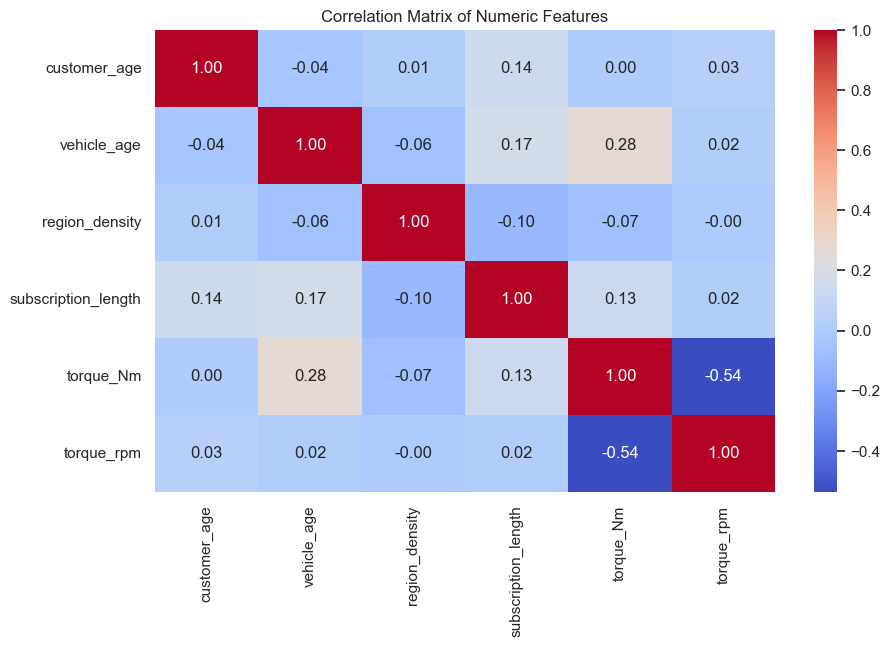

In [107]:

# ------------------------------------------------
# ✅ 3. Multivariate Correlation Heatmap (Numerics)
# ------------------------------------------------
numeric_cols = ['customer_age', 'vehicle_age', 'region_density', 'subscription_length', 'torque_Nm', 'torque_rpm']
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numeric Features")
plt.show()


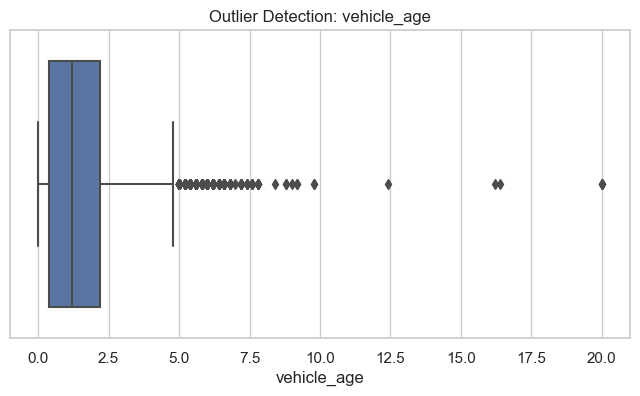

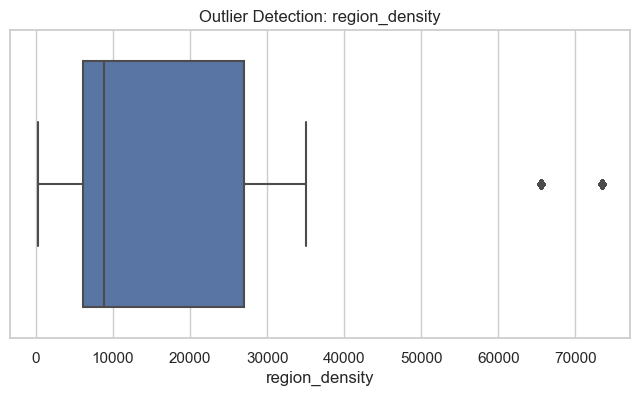

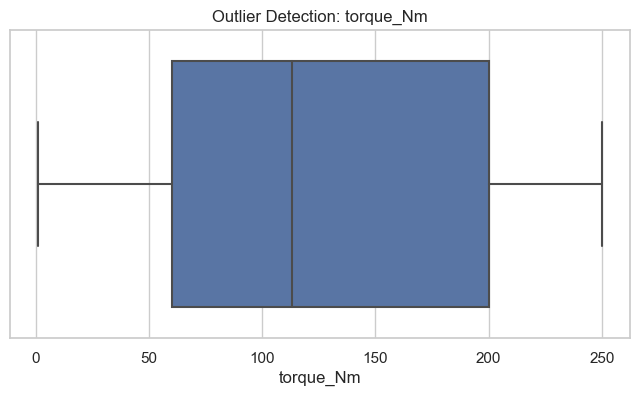

In [108]:

# -----------------------------
# ✅ 4. Outlier Detection
# -----------------------------
outlier_cols = ['vehicle_age', 'region_density', 'torque_Nm']
for col in outlier_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Outlier Detection: {col}')
    plt.show()


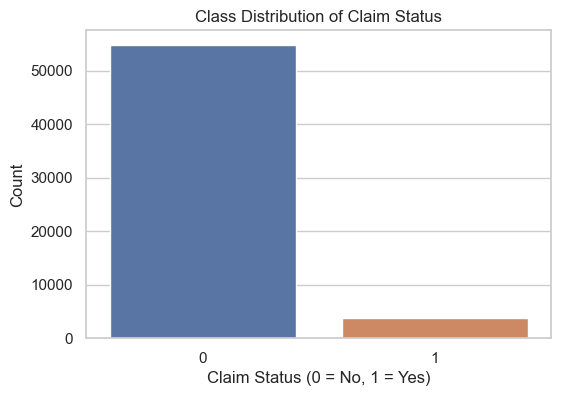

In [109]:

# --------------------------------------
# ✅ 5. Target Distribution (Claim Status)
# --------------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(x='claim_status', data=df)
plt.title('Class Distribution of Claim Status')
plt.xlabel("Claim Status (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [110]:
df['torque_Nm'].describe()

count    58592.000000
mean       128.674887
std         79.939410
min          1.000000
25%         60.000000
50%        113.000000
75%        200.000000
max        250.000000
Name: torque_Nm, dtype: float64

In [111]:
df = df[df['torque_Nm'] != 1]

In [112]:
df=df[df['subscription_length']!=0]

In [113]:
df['log_region_density'] = np.log1p(df['region_density']) 

In [114]:
df['vehicle_age_bin'] = pd.cut(df['vehicle_age'], bins=[-1, 1, 3, 10, 100], labels=['<1yr', '1-3yr', '3-10yr', '10yr+'])

In [115]:
model_claim_mean = df.groupby('model')['claim_status'].mean().sort_values(ascending=False)
print(model_claim_mean)


model
M2     0.074766
M5     0.072464
M7     0.068507
M6      0.06845
M4     0.064569
M9     0.063213
M1     0.061576
M10    0.060783
M3     0.054237
M11    0.041436
Name: claim_status, dtype: Float64


In [116]:
model_freq = df['model'].value_counts()
df['model_encoded'] = df['model'].map(model_freq)


In [117]:
# Ensure the order is correct (if not already)
df['vehicle_age_bin'] = df['vehicle_age_bin'].cat.reorder_categories(
    ['<1yr', '1-3yr', '3-10yr', '10yr+'], ordered=True
)

# Convert to numeric codes
df['vehicle_age_bin_encoded'] = df['vehicle_age_bin'].cat.codes

In [118]:
drop_cols = [
    'policy_id',
    'model',
    'region_code',
    'max_torque',
    'region_density',
    'vehicle_age',
    'age_bin',
    'vehicle_age_bin'
]

df = df.drop(columns=drop_cols, errors='ignore')


In [123]:
df

,subscription_length,customer_age,fuel_type,segment,claim_status,torque_Nm,torque_rpm,log_region_density,model_encoded,vehicle_age_bin_encoded
0,5.6,49,Petrol,A,0,91.0,4250.0,8.515392,2360,1
1,1.0,35,Petrol,A,0,91.0,4250.0,8.515392,2360,0
2,3.7,51,Petrol,A,0,91.0,4250.0,8.515392,2360,0
3,2.3,43,Petrol,A,0,91.0,4250.0,8.515392,2360,0
4,6.4,53,Petrol,A,0,91.0,4250.0,8.515392,2360,0
...,...,...,...,...,...,...,...,...,...,...
58587,0.9,49,Diesel,C1,0,200.0,1750.0,9.787235,2104,0
58588,11.9,51,Diesel,C1,0,200.0,1750.0,9.787235,2104,1
58589,3.7,42,Diesel,C1,0,200.0,1750.0,9.787235,2104,1
58590,2.4,60,Diesel,C1,0,200.0,1750.0,9.787235,2104,1


In [125]:
df_encoded = pd.get_dummies(df, columns=['fuel_type', 'segment'], drop_first=True)

In [127]:
bool_cols = ['fuel_type_Diesel', 'fuel_type_Petrol', 'segment_B2', 'segment_C1', 'segment_C2', 'segment_Utility']
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [129]:
df_encoded.to_csv("final_insurance_data.csv", index=False)